In [51]:
from sklearn.cluster import *
import scipy
import copy
import numpy as np
from matplotlib import pyplot as plt
from Bio import AlignIO
import pickle
import h5py
import dendropy
#todo. blur mat up and down tree
#todo. group codons
import os
os.environ['MKL_ENABLE_INSTRUCTIONS'] = 'AVX2'


In [52]:
treefile = '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/gisaid_hcov-2020_07_02.QC.NSoutlier.filter.NSmask.aln.treefile'
alnfile = '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/gisaid_hcov-2020_07_02.QC.NSoutlier.filter.NSmask.aln'
outsankof = './coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/gisaid_hcov-2020_07_02.QC.NSoutlier.filter.NSmask.alnCOEV_cleantreecoevmatrev3.pkl'

In [53]:
treefile = '/home/cactuskid13/covid/lucy_mk2/30_07_2020/gisaid_hcov-2020_07_30.QC.NSoutlier.filter.deMaiomask.aln.EPIID.HF.treefile'
alnfile = '/home/cactuskid13/covid/lucy_mk2/30_07_2020/gisaid_hcov-2020_07_30.QC.NSoutlier.filter.deMaiomask.EPIID.HF.noambig.aln'
outsankof = './lucy_mk2/30_07_2020/gisaid_hcov-2020_07_30.QC.NSoutlier.filter.deMaiomask.EPIID.HF.noambig.HomoplasyFinder_input.alnCOEV_cleantree_mk4coevmatrev3.pkl'

In [54]:
treefile = './lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.aln.EPIID.treefile'
alnfile = './lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.aln'
outsankof = './lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk5coevmatrev3.pkl'

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(109535, 29903)
1.0


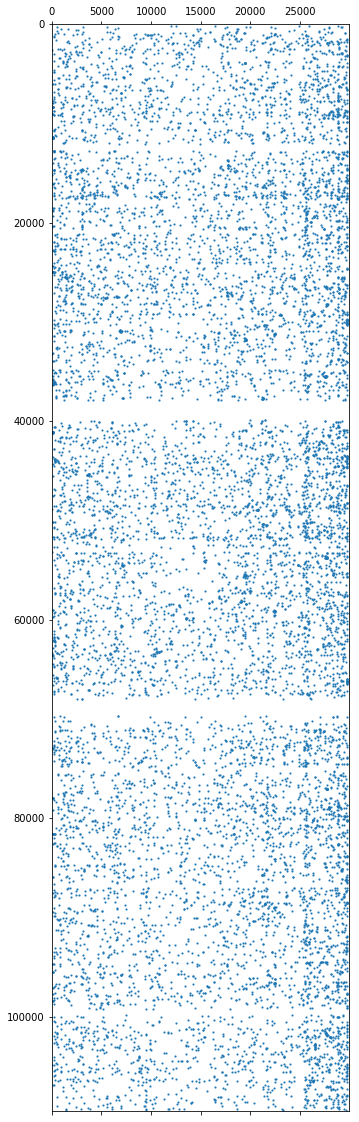

In [55]:
#load sankoff coev mat
with open( outsankof , 'rb') as matin:
    coevmat = pickle.loads(matin.read())
coevmat = coevmat.todense()
print(coevmat)
print(coevmat.shape)
print(np.amax(coevmat))

plt.figure( figsize=(30,20))
plt.spy(coevmat, markersize= 1)
plt.show()

In [56]:
sumv = np.sum(coevmat , axis = 0)
print(sumv.ravel().shape)
print(np.amax(sumv))
print(np.amin(sumv))
print(np.mean(sumv))
print(np.mean(sumv[sumv>0]))
print(np.std(sumv))

(1, 29903)
34.0
0.0
0.4036718723873859
2.6082541054451167
1.4179716647579308


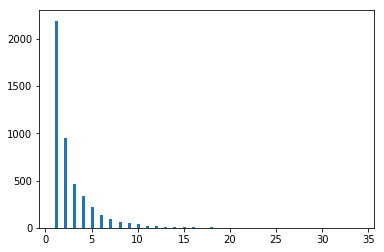

In [57]:
counts,bins = np.histogram(sumv[sumv>0].ravel() , bins = 100)
centroids = (bins[1:] + bins[:-1]) / 2
counts_, bins_, _ = plt.hist(centroids, bins=len(counts),
                             weights=counts, range=(min(bins), max(bins)))

In [58]:
#create the connectivity mat and use it to blur the coev mat
tree = dendropy.Tree.get(
    path=treefile,
    schema='newick')
for l in tree.leaf_nodes()[0:10]:
    print(str(l.taxon))
print(len(tree.leaf_nodes()))
print('leaves')

for i,n in enumerate(tree.nodes()):
    n.matrow = i
    n.symbols = None
    n.scores = None
    n.event = None
    n.char = None
matsize = len(tree.nodes())
print(matsize)
print('nodes')



'EPI ISL 475635'
'EPI ISL 425848'
'EPI ISL 433289'
'EPI ISL 439066'
'EPI ISL 433434'
'EPI ISL 417064'
'EPI ISL 434563'
'EPI ISL 434564'
'EPI ISL 425865'
'EPI ISL 464788'
54768
leaves
109535
nodes


In [59]:
#blur w connectivity mat
blurfactor =  .5
bluriter = 4
connectmat = scipy.sparse.lil_matrix((len(tree.nodes()), len(tree.nodes() ) ) )
index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
connectmat[index[:,0],index[:,1]] = 1
connectmat[index[:,1],index[:,0]] = 1

#connectmat+= connectmat.T

In [60]:
splitrange = (500, 5000)
bins =[]
def split_tree( n , splitrange , bins):
    for c in n.child_nodes():
        progeny = [ d for d in  c.ageorder_iter() ] 
        if len(progeny ) > splitrange[0] and len(progeny) < splitrange[1]:
            bins.append(c)
        else:
            split_tree( c , splitrange , bins )
    return bins

bins =[]
bins = split_tree(tree.seed_node, splitrange, bins)
binsize = [ len( [ n for n in c.ageorder_iter() ]) for c  in bins]

TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

In [ ]:
plt.figure( figsize=(20,20))
plt.spy(connectmat, markersize= 1)
plt.show()

In [15]:
#apply blur a few times
blurmat = copy.deepcopy(scipy.sparse.lil_matrix(coevmat))
print(connectmat.shape)
print(blurmat.shape)
for i in range( bluriter):
    blurmat += np.dot(blurfactor*connectmat, blurmat)
    print('blurring')
    print(i)

(109535, 109535)
(109535, 29903)
blurring
0
blurring
1
blurring
2
blurring
3


In [18]:
with open(alnfile+'blurmatr3.pkl' , 'wb') as blurout:
    blurout.write( pickle.dumps(blurmat ))


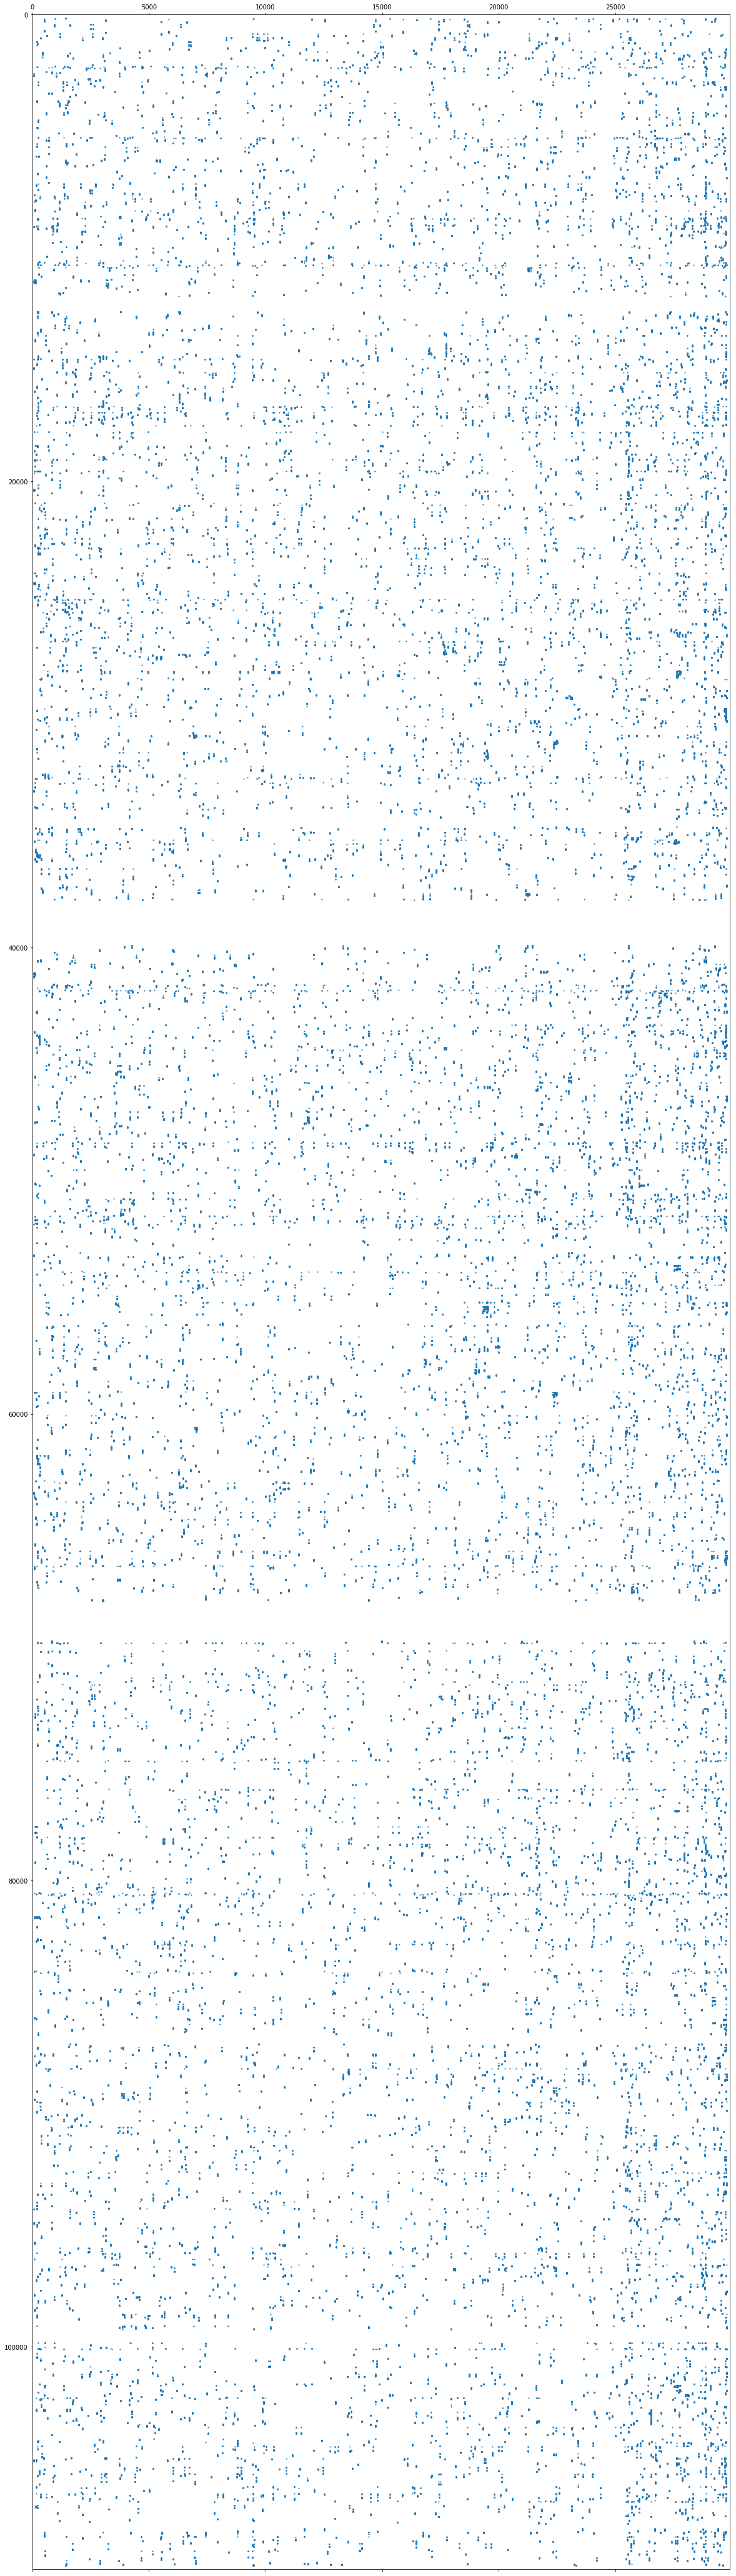

In [19]:
plt.figure( figsize=(20,200))
plt.spy(blurmat , markersize= 1)
plt.show()

In [21]:
with open(alnfile+'blurmatr3.pkl' , 'rb') as blurout:
    blurmat = pickle.loads( blurout.read())
blurmat = blurmat.todense()



In [22]:
blursum = np.sum(blurmat , axis = 1)
print(blursum.shape)

(109535, 1)


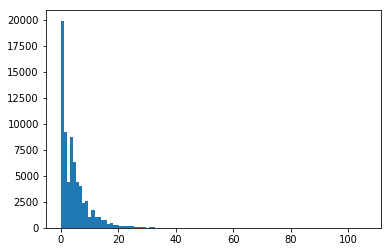

In [24]:
counts,bins = np.histogram(blursum[blursum>0].ravel() , bins = 100)
centroids = (bins[1:] + bins[:-1]) / 2
counts_, bins_, _ = plt.hist(centroids, bins=len(counts),
                             weights=counts, range=(min(bins), max(bins)))
